In [1]:
import pandas as pd
import os
import re
import openpyxl

In [2]:
print(os.getcwd())

/home/notvisal/Desktop/Intern/Knife_Sharpness_Dataset


In [3]:
P1_contents = os.listdir('Theme2/P1/Boning/')

print(P1_contents)

['MVN-J-Boning-64-001.xlsx', 'MVN-J-Boning-90-003.xlsx', 'MVN-J-Boning-90-002.xlsx', 'MVN-J-Boning-90-004.xlsx', 'MVN-J-Boning-64-006.xlsx', 'MVN-J-Boning-64-004.xlsx', 'MVN-J-Boning-64-002.xlsx', 'MVN-J-Boning-90-001.xlsx', 'MVN-J-Boning-64-003.xlsx', 'MVN-J-Boning-79-001.xlsx', 'MVN-J-Boning-64-005.xlsx']


In [4]:
P1_BONING_PATHS = [
    'Theme2/P1/Boning/MVN-J-Boning-64-001.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-90-003.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-90-002.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-90-004.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-64-006.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-64-004.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-64-002.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-90-001.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-64-003.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-79-001.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-64-005.xlsx'
]

SELECTED_SHEETS = [
    'General Information', 
    'Markers', 
    'Segment Orientation - Quat', 
    'Segment Orientation - Euler', 
    'Segment Position', 
    'Segment Velocity', 
    'Segment Acceleration', 
    'Segment Angular Velocity', 
    'Segment Angular Acceleration', 
    'Joint Angles ZXY', 
    'Joint Angles XZY', 
    'Ergonomic Joint Angles ZXY', 
    'Ergonomic Joint Angles XZY', 
    'Center of Mass', 
    'Sensor Free Acceleration', 
    'Sensor Magnetic Field', 
    'Sensor Orientation - Quat', 
    'Sensor Orientation - Euler'
]

In [5]:
xls_file = pd.ExcelFile(P1_BONING_PATHS[5])

print(xls_file.sheet_names)

['General Information', 'Markers', 'Segment Orientation - Quat', 'Segment Orientation - Euler', 'Segment Position', 'Segment Velocity', 'Segment Acceleration', 'Segment Angular Velocity', 'Segment Angular Acceleration', 'Joint Angles ZXY', 'Joint Angles XZY', 'Ergonomic Joint Angles ZXY', 'Ergonomic Joint Angles XZY', 'Center of Mass', 'Sensor Free Acceleration', 'Sensor Magnetic Field', 'Sensor Orientation - Quat', 'Sensor Orientation - Euler']


In [13]:
for sheet in SELECTED_SHEETS:
    df = xls_file.parse(sheet)

    print(f"{df.columns.tolist()} \n")
      
# see the missing cols
# missing_vals = df.isna().sum()
# missing_vals[missing_vals > 0]

['MVN version', '2023.0.0'] 

['Frame', 'Labelling', 'Unnamed: 2', 'Unnamed: 3'] 

['Frame', 'Label', 'Pelvis q0', 'Pelvis q1', 'Pelvis q2', 'Pelvis q3', 'L5 q0', 'L5 q1', 'L5 q2', 'L5 q3', 'L3 q0', 'L3 q1', 'L3 q2', 'L3 q3', 'T12 q0', 'T12 q1', 'T12 q2', 'T12 q3', 'T8 q0', 'T8 q1', 'T8 q2', 'T8 q3', 'Neck q0', 'Neck q1', 'Neck q2', 'Neck q3', 'Head q0', 'Head q1', 'Head q2', 'Head q3', 'Right Shoulder q0', 'Right Shoulder q1', 'Right Shoulder q2', 'Right Shoulder q3', 'Right Upper Arm q0', 'Right Upper Arm q1', 'Right Upper Arm q2', 'Right Upper Arm q3', 'Right Forearm q0', 'Right Forearm q1', 'Right Forearm q2', 'Right Forearm q3', 'Right Hand q0', 'Right Hand q1', 'Right Hand q2', 'Right Hand q3', 'Left Shoulder q0', 'Left Shoulder q1', 'Left Shoulder q2', 'Left Shoulder q3', 'Left Upper Arm q0', 'Left Upper Arm q1', 'Left Upper Arm q2', 'Left Upper Arm q3', 'Left Forearm q0', 'Left Forearm q1', 'Left Forearm q2', 'Left Forearm q3', 'Left Hand q0', 'Left Hand q1', 'Left Hand q2', 'L

# **Understanding the Dataset (small scale)**

In [7]:
file_paths = [
    'Theme2/P1/Boning/MVN-J-Boning-64-004.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-90-004.xlsx', 
    'Theme2/P1/Boning/MVN-J-Boning-79-001.xlsx'
]

# Sharpness levels corresponding to filenames
sharpness_levels = [64, 73, 87]

# clean and balance each files
def clean_and_balance(file, sharpness, target_sampling_rate=25):
    xls = pd.ExcelFile(file)
    all_sheets = []
    all_columns = set()

    def undersample_group(group, min_count, target_sampling_rate):
        """
        the function takes a group (a subset of data corresponding to activity label) and the min_count, and it performs the sampling operation
        """
        num_samples = int(len(group) / target_sampling_rate)

        return group.sample(n=num_samples, random_state=42)
    
    for sheet_name in xls.sheet_names:
        df = pd.read_excel(xls, sheet_name=sheet_name)
        print(f"processing {sheet_name}, initial shape: {df.shape}")
        df['sharpness'] = sharpness # assign 'sharpness' as a new col

        #check if 'label' column exists
        if 'Label' not in df.columns:
            print(f"skipping {sheet_name}")
            continue

        #cleaning
        df.dropna(inplace=True)
        print(f"after dropna: {df.shape}")

        all_columns.update(df.columns)

        #balancing
        activity_counts = df['Label'].value_counts()
        min_count = activity_counts.min()
        
        # undersample the data based on activity labels
        df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)

        print(f"after undersampling: {df_balanced.shape}")
        
        all_sheets.append(df_balanced)

    # combine all sheets from the current file and align columns
    all_columns = list(all_columns)
    
    for i in range(len(all_sheets)):
        df = all_sheets[i]
        # reindex to align columns, filling missing ones with Nan
        df = df.reindex(columns=all_columns, fill_value=pd.NA)
        all_sheets[i] = df

        print(f"after reindexing sheet {i+1}: {df.shape}")

    # combine all sheets from the current file q
    return pd.concat(all_sheets, ignore_index=True, join='outer')

# read, clean, and balance all files
df_all = []
for file, sharpness in zip(file_paths, sharpness_levels):
    df_cleaned = clean_and_balance(file, sharpness, target_sampling_rate=25)
    df_all.append(df_cleaned)


# merge all cleaned and balanced data into a single dataframe
df_final = pd.concat(df_all, ignore_index=True, join='outer')

print(df_final.head(50))
    

processing General Information, initial shape: (5, 2)
skipping General Information
processing Markers, initial shape: (10, 4)
skipping Markers
processing Segment Orientation - Quat, initial shape: (5033, 94)
after dropna: (5033, 95)
after undersampling: (198, 95)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Segment Orientation - Euler, initial shape: (5033, 71)
after dropna: (5033, 72)
after undersampling: (198, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Segment Position, initial shape: (5033, 71)
after dropna: (5033, 72)
after undersampling: (198, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Segment Velocity, initial shape: (5033, 71)
after dropna: (5033, 72)
after undersampling: (198, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Segment Acceleration, initial shape: (5033, 71)
after dropna: (5033, 72)
after undersampling: (198, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Segment Angular Velocity, initial shape: (5033, 71)
after dropna: (5033, 72)
after undersampling: (198, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Segment Angular Acceleration, initial shape: (5033, 71)
after dropna: (5033, 72)
after undersampling: (198, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Joint Angles ZXY, initial shape: (5033, 68)
after dropna: (5033, 69)
after undersampling: (198, 69)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Joint Angles XZY, initial shape: (5033, 68)
after dropna: (5033, 69)
after undersampling: (198, 69)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Ergonomic Joint Angles ZXY, initial shape: (5033, 20)
after dropna: (5033, 21)
after undersampling: (198, 21)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Ergonomic Joint Angles XZY, initial shape: (5033, 20)
after dropna: (5033, 21)
after undersampling: (198, 21)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Center of Mass, initial shape: (5033, 11)
after dropna: (5033, 12)
after undersampling: (198, 12)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Sensor Free Acceleration, initial shape: (5033, 71)
after dropna: (5033, 72)
after undersampling: (198, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Sensor Magnetic Field, initial shape: (5033, 71)
after dropna: (5033, 72)
after undersampling: (198, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Sensor Orientation - Quat, initial shape: (5033, 94)
after dropna: (5033, 95)
after undersampling: (198, 95)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Sensor Orientation - Euler, initial shape: (5033, 71)
after dropna: (5033, 72)
after undersampling: (198, 72)
after reindexing sheet 1: (198, 257)
after reindexing sheet 2: (198, 257)
after reindexing sheet 3: (198, 257)
after reindexing sheet 4: (198, 257)
after reindexing sheet 5: (198, 257)
after reindexing sheet 6: (198, 257)
after reindexing sheet 7: (198, 257)
after reindexing sheet 8: (198, 257)
after reindexing sheet 9: (198, 257)
after reindexing sheet 10: (198, 257)
after reindexing sheet 11: (198, 257)
after reindexing sheet 12: (198, 257)
after reindexing sheet 13: (198, 257)
after reindexing sheet 14: (198, 257)
after reindexing sheet 15: (198, 257)
after reindexing sheet 16: (198, 257)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)
/tmp/ipykernel_5351/1954022068.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_sheets, ignore_index=True, join='outer')


processing General Information, initial shape: (5, 2)
skipping General Information
processing Markers, initial shape: (41, 4)
skipping Markers
processing Segment Orientation - Quat, initial shape: (20405, 94)
after dropna: (20405, 95)
after undersampling: (813, 95)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Segment Orientation - Euler, initial shape: (20405, 71)
after dropna: (20405, 72)
after undersampling: (813, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Segment Position, initial shape: (20405, 71)
after dropna: (20405, 72)
after undersampling: (813, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Segment Velocity, initial shape: (20405, 71)
after dropna: (20405, 72)
after undersampling: (813, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Segment Acceleration, initial shape: (20405, 71)
after dropna: (20405, 72)
after undersampling: (813, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Segment Angular Velocity, initial shape: (20405, 71)
after dropna: (20405, 72)
after undersampling: (813, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Segment Angular Acceleration, initial shape: (20405, 71)
after dropna: (20405, 72)
after undersampling: (813, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Joint Angles ZXY, initial shape: (20405, 68)
after dropna: (20405, 69)
after undersampling: (813, 69)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Joint Angles XZY, initial shape: (20405, 68)
after dropna: (20405, 69)
after undersampling: (813, 69)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Ergonomic Joint Angles ZXY, initial shape: (20405, 20)
after dropna: (20405, 21)
after undersampling: (813, 21)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Ergonomic Joint Angles XZY, initial shape: (20405, 20)
after dropna: (20405, 21)
after undersampling: (813, 21)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Center of Mass, initial shape: (20405, 11)
after dropna: (20405, 12)
after undersampling: (813, 12)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Sensor Free Acceleration, initial shape: (20405, 71)
after dropna: (20405, 72)
after undersampling: (813, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Sensor Magnetic Field, initial shape: (20405, 71)
after dropna: (20405, 72)
after undersampling: (813, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Sensor Orientation - Quat, initial shape: (20405, 94)
after dropna: (20405, 95)
after undersampling: (813, 95)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Sensor Orientation - Euler, initial shape: (20405, 71)
after dropna: (20405, 72)
after undersampling: (813, 72)
after reindexing sheet 1: (813, 257)
after reindexing sheet 2: (813, 257)
after reindexing sheet 3: (813, 257)
after reindexing sheet 4: (813, 257)
after reindexing sheet 5: (813, 257)
after reindexing sheet 6: (813, 257)
after reindexing sheet 7: (813, 257)
after reindexing sheet 8: (813, 257)
after reindexing sheet 9: (813, 257)
after reindexing sheet 10: (813, 257)
after reindexing sheet 11: (813, 257)
after reindexing sheet 12: (813, 257)
after reindexing sheet 13: (813, 257)
after reindexing sheet 14: (813, 257)
after reindexing sheet 15: (813, 257)
after reindexing sheet 16: (813, 257)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)
/tmp/ipykernel_5351/1954022068.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_sheets, ignore_index=True, join='outer')


processing General Information, initial shape: (5, 2)
skipping General Information
processing Markers, initial shape: (88, 4)
skipping Markers
processing Segment Orientation - Quat, initial shape: (54193, 94)
after dropna: (54193, 95)
after undersampling: (2165, 95)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Segment Orientation - Euler, initial shape: (54193, 71)
after dropna: (54193, 72)
after undersampling: (2165, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Segment Position, initial shape: (54193, 71)
after dropna: (54193, 72)
after undersampling: (2165, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Segment Velocity, initial shape: (54193, 71)
after dropna: (54193, 72)
after undersampling: (2165, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Segment Acceleration, initial shape: (54193, 71)
after dropna: (54193, 72)
after undersampling: (2165, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Segment Angular Velocity, initial shape: (54193, 71)
after dropna: (54193, 72)
after undersampling: (2165, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Segment Angular Acceleration, initial shape: (54193, 71)
after dropna: (54193, 72)
after undersampling: (2165, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Joint Angles ZXY, initial shape: (54193, 68)
after dropna: (54193, 69)
after undersampling: (2165, 69)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Joint Angles XZY, initial shape: (54193, 68)
after dropna: (54193, 69)
after undersampling: (2165, 69)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Ergonomic Joint Angles ZXY, initial shape: (54193, 20)
after dropna: (54193, 21)
after undersampling: (2165, 21)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Ergonomic Joint Angles XZY, initial shape: (54193, 20)
after dropna: (54193, 21)
after undersampling: (2165, 21)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Center of Mass, initial shape: (54193, 11)
after dropna: (54193, 12)
after undersampling: (2165, 12)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Sensor Free Acceleration, initial shape: (54193, 71)
after dropna: (54193, 72)
after undersampling: (2165, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Sensor Magnetic Field, initial shape: (54193, 71)
after dropna: (54193, 72)
after undersampling: (2165, 72)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Sensor Orientation - Quat, initial shape: (54193, 94)
after dropna: (54193, 95)
after undersampling: (2165, 95)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)


processing Sensor Orientation - Euler, initial shape: (54193, 71)
after dropna: (54193, 72)
after undersampling: (2165, 72)
after reindexing sheet 1: (2165, 257)
after reindexing sheet 2: (2165, 257)
after reindexing sheet 3: (2165, 257)
after reindexing sheet 4: (2165, 257)
after reindexing sheet 5: (2165, 257)
after reindexing sheet 6: (2165, 257)
after reindexing sheet 7: (2165, 257)
after reindexing sheet 8: (2165, 257)
after reindexing sheet 9: (2165, 257)
after reindexing sheet 10: (2165, 257)
after reindexing sheet 11: (2165, 257)
after reindexing sheet 12: (2165, 257)
after reindexing sheet 13: (2165, 257)
after reindexing sheet 14: (2165, 257)
after reindexing sheet 15: (2165, 257)
after reindexing sheet 16: (2165, 257)


/tmp/ipykernel_5351/1954022068.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('Label', group_keys=False).apply(undersample_group, min_count=min_count, target_sampling_rate=target_sampling_rate).reset_index(drop=True)
/tmp/ipykernel_5351/1954022068.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_sheets, ignore_index=True, join='outer')


    Left Foot q3  sharpness  Right Forearm q3  Right Hand x  \
0       0.865610         64         -0.718660           NaN   
1       0.865656         64          0.713075           NaN   
2       0.688674         64          0.646431           NaN   
3       0.688976         64          0.634212           NaN   
4       0.865822         64          0.711837           NaN   
5       0.683083         64          0.563166           NaN   
6       0.689116         64          0.635806           NaN   
7       0.688185         64          0.638977           NaN   
8       0.688351         64          0.650868           NaN   
9       0.683341         64          0.636691           NaN   
10      0.688837         64          0.635530           NaN   
11      0.688947         64          0.642542           NaN   
12      0.688885         64          0.650407           NaN   
13      0.678483         64          0.673842           NaN   
14      0.684052         64          0.629120          

In [8]:
df_final.head()

,Left Foot q3,sharpness,Right Forearm q3,Right Hand x,Left Shoulder Flexion/Extension,Pelvis_T8 Flexion/Extension,T12 x,Pelvis q2,Head z,Pelvis q3,...,Right Upper Arm x,T8_LeftUpperArm Flexion/Extension,Left T4 Shoulder Internal/External Rotation,Left Hand q2,Left Upper Leg q1,Left Forearm q3,Right Toe q2,Right Upper Arm y,Right Upper Leg q0,Right Toe y
0,0.865610,64,-0.718660,NaN,NaN,NaN,NaN,-0.027807,NaN,0.898629,...,NaN,NaN,NaN,-0.599872,0.011619,0.579465,0.009199,NaN,0.382298,NaN
1,0.865656,64,0.713075,NaN,NaN,NaN,NaN,-0.053318,NaN,0.795379,...,NaN,NaN,NaN,-0.230386,0.003779,0.343807,-0.038352,NaN,0.629217,NaN
2,0.688674,64,0.646431,NaN,NaN,NaN,NaN,-0.063365,NaN,0.628359,...,NaN,NaN,NaN,0.162143,-0.033012,0.199350,-0.071677,NaN,0.759949,NaN
3,0.688976,64,0.634212,NaN,NaN,NaN,NaN,-0.069118,NaN,0.642753,...,NaN,NaN,NaN,-0.159241,0.032945,0.213792,-0.067852,NaN,0.742035,NaN
4,0.865822,64,0.711837,NaN,NaN,NaN,NaN,-0.058039,NaN,0.791515,...,NaN,NaN,NaN,-0.228681,0.007917,0.343840,-0.036427,NaN,0.631574,NaN


In [33]:
df_final['Frame'].head()

0    1171
1    1409
2    1797
3    2125
4    1487
Name: Frame, dtype: int64

In [21]:
df_final['Right Hand x'].isna().sum()

np.int64(22232)

In [26]:
for cols in df_final.columns.tolist():
    if df_final[cols].nunique() ==0:
        print(f"{cols}: {df_final[cols].nunique()}")

In [103]:
features_to_plot = ['Left Foot q3', 'Right Forearm q3', 'sharpness']

df_final = df_final.sort_values(by="Frame").reset_index(drop=True)


def smooth_data(series, window_size=5):
    return series.rolling(window=window_size, min_periods=1).mean()

df_final_smoothed = df_final.copy()
for feature in features_to_plot:
    df_final_smoothed[feature] = smooth_data(df_final[feature])


In [104]:
df_final_downsampled = df_final_smoothed.iloc[::10, :]  # Keep every 10th frame

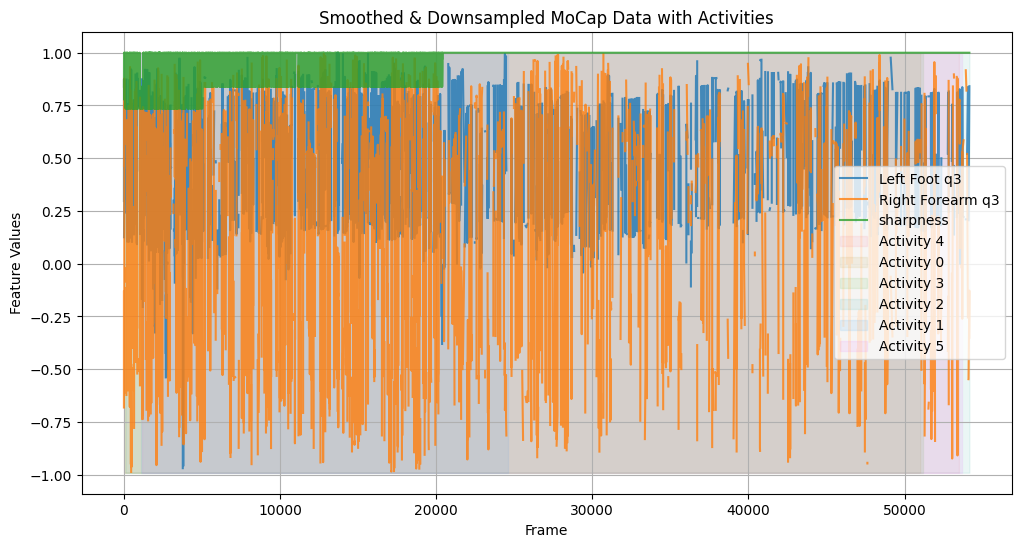

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Smooth and downsampled data
df_plot = df_final_downsampled

# Plot each feature
for feature in features_to_plot:
    plt.plot(df_plot['Frame'], df_plot[feature], label=feature, alpha=0.8)

# Shade background based on activity labels
unique_activities = df_plot['Label'].unique()
activity_colors = sns.color_palette("husl", len(unique_activities))

for i, activity in enumerate(unique_activities):
    activity_rows = df_plot[df_plot['Label'] == activity]
    plt.fill_between(activity_rows['Frame'], df_plot[features_to_plot].min().min(), 
                     df_plot[features_to_plot].max().max(), 
                     color=activity_colors[i], alpha=0.1, label=f'Activity {activity}')

plt.xlabel("Frame")
plt.ylabel("Feature Values")
plt.title("Smoothed & Downsampled MoCap Data with Activities")
plt.legend()
plt.grid(True)
plt.show()


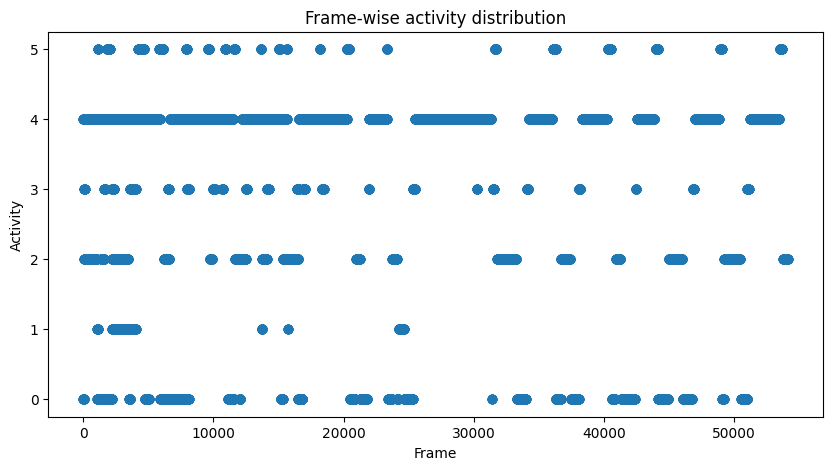

In [42]:
plt.figure(figsize=(10, 5))
plt.scatter(frame_activity_df['Frame'], frame_activity_df['Activity'], alpha=0.5)
plt.xlabel('Frame')
plt.ylabel('Activity')
plt.title('Frame-wise activity distribution')
plt.show()
